In [9]:
library(tidyverse)
library(h2o)
library(recipes)
library(rsample)

library(xgboost)
library(vip)
library(vip)
library(iml)
library(DALEX)
library(lime)

## 머린러닝 해석
1. 전역규모로 훈련한 모델을 이해하고, 데이터 또는 예측의 국소영역을 확대하고 설명하는 것이 중요

### 전역해석
- 전역해석 가능성은 변수에 대한 전체적인 관점과 기본 모델 구조에 미치는 영향을 기반으로 모델이 예측을 수행하는 방법을 이해하는 것
- 어떤 변수가 상대적으로 영향력이 있는지, 이러한 변수가 반응변수에 어떤 영향을 미치는지, 어떤 종류의 잠재적 상호작용이 발생하는지에 대한 질문에 답함.
- 전역해석 가능성은 반응변수와 개별 변수(또는 그 하위 집합)간의 관계를 이해하는 데 도움이 된다
- 전역해석 가능성은 실제로 달성하기가 매우 어렵다. 소수의 변수를 초과하는 모델은 전체 모델구조를 한 번에 이해할 수 없기 때문에 완전히 파악하기 어렵다.

- 전역모델 해석은 일반적으로 도달할 수 없지만 모듈 수준에서 최소한 일부 모델을 이해할 수 있는 더 나은 기회가 있다. 
- 일반적으로 어떤 변수가 가장 영향력이 있는지(변수 중요도) 
- 이해를 얻은 다음 가장 영향력 있는 변수가 어떻게 모델 출력을 유도하는지에 초점을 맞추는 것과 관련(변수효과 를 통해). 
- 100개의 변수가 있는 모델을 완전히 파악하지 못할 수도 있지만 일반적으로 이러한 변수 중 12개 정도만이 모델의 성능을 주도하는 데 실제로 영향을 미친다. 그리고 12개의 변수가 모델에 어떤 영향을 미치는지 확실히 파악할 수 있다.

### 국소해석
- 전역해석 방법은 입력 및 반응변수와의 전반적인 관계를 이해하는 데 도움이 되지만 일부 경우(예: 강력한 상호 작용이 발생할 때) 매우 기만적일 수 있습니다. 
- 주어진 변수가 전체 모델의 예측 정확도에 영향을 미칠 수 있지만, 해당 변수가 주어진 관찰값(예: 고객, 집 또는 직원) 또는 그룹에 대한 예측 값에 가장 큰 영향을 미친다는 의미는 아니다. 
- 국소해석은 주어진 관찰값(또는 소규모 관찰 그룹)에 대한 예측 반응에 어떤 기능이 영향을 미치는지 이해하는 데 도움이 된다. 
- 이러한 기술은 고객이 무엇을 하기를 기대하는지 뿐만 아니라 우리 모델이 주어진 관찰에 대해 특정 예측을 하는 이유에 대해서도 답하는 데 도움이 된다.

#### 국소해석의 접근방식
1. LIME
2. Shapley values
3. Localized step-wise procedures

- 어떤 변수가 일련의 관찰에 대한 목표를 예측하는 데 가장 영향력이 있는지 설명하는 것

In [24]:
h2o.no_progress()
h2o.init(max_mem_size = "5g")

ames <- AmesHousing::make_ames()
set.seed(123)  # for reproducibility
split <- initial_split(ames, strata = "Sale_Price")
ames_train <- training(split)
ames_test <- testing(split)

blueprint <- recipe(Sale_Price ~ ., data = ames_train) %>%
  step_other(all_nominal(), threshold = .005)

train_h2o <- prep(blueprint, training = ames_train, retain = TRUE) %>%
  juice() %>%
  as.h2o()
test_h2o <- prep(blueprint, training = ames_train) %>%
  bake(new_data = ames_test) %>%
  as.h2o()

Y <- "Sale_Price"
X <- setdiff(names(ames_train), Y)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\APF_TE~1\AppData\Local\Temp\Rtmp8wxV0t\file135444e42cc9/h2o_apf_temp_admin_started_from_r.out
    C:\Users\APF_TE~1\AppData\Local\Temp\Rtmp8wxV0t\file13543496540c/h2o_apf_temp_admin_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         12 seconds 271 milliseconds 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    8 days  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_trg721 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   4.44 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection pr

In [ ]:
best_glm <- h2o.glm(
  x = X, y = Y, training_frame = train_h2o, alpha = 0.1,
  remove_collinear_columns = TRUE, nfolds = 10, fold_assignment = "Modulo",
  keep_cross_validation_predictions = TRUE, seed = 123
)

# Train & cross-validate a RF model
best_rf <- h2o.randomForest(
  x = X, y = Y, training_frame = train_h2o, ntrees = 1000, mtries = 20,
  max_depth = 30, min_rows = 1, sample_rate = 0.8, nfolds = 10,
  fold_assignment = "Modulo", keep_cross_validation_predictions = TRUE,
  seed = 123, stopping_rounds = 50, stopping_metric = "RMSE",
  stopping_tolerance = 0
)

# Train & cross-validate a GBM model
best_gbm <- h2o.gbm(
  x = X, y = Y, training_frame = train_h2o, ntrees = 5000, learn_rate = 0.01,
  max_depth = 7, min_rows = 5, sample_rate = 0.8, nfolds = 10,
  fold_assignment = "Modulo", keep_cross_validation_predictions = TRUE,
  seed = 123, stopping_rounds = 50, stopping_metric = "RMSE",
  stopping_tolerance = 0
)

# Train & cross-validate an XGBoost model
best_xgb <- h2o.xgboost(
  x = X, y = Y, training_frame = train_h2o, ntrees = 5000, learn_rate = 0.05,
  max_depth = 3, min_rows = 3, sample_rate = 0.8, categorical_encoding = "Enum",
  nfolds = 10, fold_assignment = "Modulo", 
  keep_cross_validation_predictions = TRUE, seed = 123, stopping_rounds = 50,
  stopping_metric = "RMSE", stopping_tolerance = 0
)

# Train a stacked tree ensemble
ensemble_tree <- h2o.stackedEnsemble(
  x = X, y = Y, training_frame = train_h2o, model_id = "my_tree_ensemble",
  base_models = list(best_glm, best_rf, best_gbm, best_xgb),
  metalearner_algorithm = "drf"
)

In [ ]:
predictions <- predict(ensemble_tree, train_h2o) %>% as.vector()

In [ ]:
paste("Observation", which.max(predictions), 
      "has a predicted sale price of", scales::dollar(max(predictions))) 

```
## [1] "Observation 1825 has a predicted sale price of $663,136"
```

In [ ]:
paste("Observation", which.min(predictions), 
      "has a predicted sale price of", scales::dollar(min(predictions)))  

```
## [1] "Observation 139 has a predicted sale price of $47,245.45"
```

In [ ]:
high_ob <- as.data.frame(train_h2o)[which.max(predictions), ] %>% select(-Sale_Price)
low_ob  <- as.data.frame(train_h2o)[which.min(predictions), ] %>% select(-Sale_Price)

### Model-specific vs. model-agnostic (모델별 접근 vs 모델 불가지론적 접근)
- 선형 모델에서는 t-통계량의 절댓값
- 랜덤포레스트는 데이터의 OOB 부분에 대한 예측 정확도를 기록할 수 있으며 각 예측 변수를 치환한 후 동일한 작업을 수행하고 두 정확도 간의 차이를 모든 트리에 대해 평균화하고 다음으로 정규화

#### 궁극적으로 모델해석에 대한 최상의 접근 방식은 없다.
#### 여러 접근방식을 적용

### 모델 불가지론적 접근
- iml
- DALEX
- LIME

#### 모형의 예측값을 계산하는 함수 및 객체 생성

In [ ]:
features <- as.data.frame(train_h2o) %>% select(-Sale_Price)

response <- as.data.frame(train_h2o) %>% pull(Sale_Price)

pred <- function(object, newdata)  {
  results <- as.vector(h2o.predict(object, as.h2o(newdata)))
  return(results)
}

pred(ensemble_tree, features) %>% head()

```
[1] 217750.2 109165.7 178811.5 200595.1 194434.3 209172.5
```

#### iml1및 DALEX객체 생성
### ```iml::Predictor$new()```

In [ ]:
# iml model agnostic object
components_iml <- Predictor$new(
  model = ensemble_tree, 
  data = features, 
  y = response, 
  predict.fun = pred
)

### ```DALEX::explain()```

In [ ]:
# DALEX model agnostic object
components_dalex <- DALEX::explain(
  model = ensemble_tree,
  data = features,
  y = response,
  predict_function = pred
)

### 순열기반 변수 중요도
- 순열접근방식은 일부 성능 측정(예: RMSE)과 훈련데이터의 특정 변수값을 순열한 후 얻은 동일한 성능 측정 간의 차이(또는 비율)를 사용
- 주어진 손실함수에 대해 다음을 수행 
1. 모델에 대한 손실함수 계산 
2. {1,...,p}의 변수 i에 대해
    * 값을 무작위화 
    * 주어진 모델 적용 
    * 손실함수 추정 
    * 변수 중요도 계산(일부 차이/비율 측정 치환 손실과 최초 손실 사이) 
3. 변수 중요도 내림차순으로 변수 정렬

#### 1. iml 
- ```FeatureImp()``` : 순열접근방식을 사용하여 예측모델에 대한 변수 중요도
- 사용자가 일반 손실 함수를 지정하거나 미리 정의된 목록(예: ```loss``` = "mse")을 지정
- 사용자는 원래의 오차와 순열이후의 모델 오차의 차이 또는 비율로 측정되는지 여부를 지정할 수 있다. 
- 사용자는 절차의 변동성을 안정화하는 데 도움이 되도록 각 기능을 순열할 때 사용되는 반복 횟수를 지정할 수도 있다.

#### 2. DALEX
- ```variable_importance()``` : 순열 기반 변수 중요도
- 손실함수 및 중요도 가 계산되는 방법을 지정할 수 있음
- 또한 중요도를 계산하기 위해 데이터를 섞기 전에 훈련데이터를 샘플링하는 옵션도 제공(```n_sample```) 이는 계산 속도를 높이는 데 도움

#### 3. vip
-  VIP(가변 중요도 플롯)에 중점을 두고 있으며 순열접근방식을 포함하여 변수 중요도를 계산하기 위해 모델별 접근방식과, 여러 모델 불가지론적 접근 방식을 모두제공
-  vip를 사용하면 맞춤형 손실함수를 사용, 절차를 안정화하기 위해 몬테카를로 시뮬레이션을 수행, 관찰을 샘플링하고, 대규모 데이터 세트에서 런타임 속도를 높일 수 있는 병렬 계산을 수행

### ```vip()```
- ```nsim``` : 시뮬레이션 횟수
- ```method``` : 접근방식 (```"permute"``` : 순열접근방식)
- ```metric``` : 성능 메트릭 (```"RMSE"```, ```"MSE"```)
- ```sample_frac``` : 데이터의 샘플링 비율
- ```pred_wrapper``` : 예측 함수

In [ ]:
vip(
  ensemble_tree, # 모델
  train = as.data.frame(train_h2o),
  method = "permute",
  target = "Sale_Price",
  metric = "RMSE",
  nsim = 5, # 시뮬레이션 횟수
  sample_frac = 0.5, # 샘플링 비율
  pred_wrapper = pred # 예측함수
)

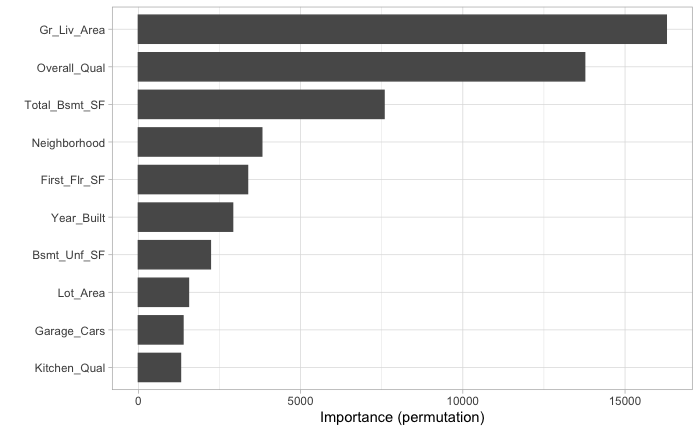

### 부분종속성 (PDP)
- 예측된 결과에 대한 변수(또는 그 하위 집합)의 한계효과를 이해하는 데 도움
- **모델에 있는 다른 모든 변수의 평균을 고려하면서 변수 값을 변경할 때 바응변수가 어떻게 변경되는지 이해**

선택한 예측 변수(x)에 대해 
1. x의 분포에 걸쳐 균일한 간격의 j 값 그리드를 구성.{x1, x2, ..., xj} 
2. {1,...,j}의 i에 대해 
    * 훈련 데이터를 복사하고 x의 원래 값을 상수 xi로 변경.  
    * 주어진 모델 적용(예: 예측 벡터 획득) 
    * 함께 평균 예측 
3. x1, x2, ..., xj에 대한 평균 예측을 플로팅

<img src = "https://bradleyboehmke.github.io/HOML/images/pdp-illustration.png">

#### 1. PDP
- 지원되지 않는 모델(h2o스택모델)의 경우 사용자 지정 예측함수를 wrap해야됨

#### 사용자 예측함수 지정 (예측된 값의 평균을 반환)

In [ ]:
pdp_pred <- function(object, newdata)  {
  results <- mean(as.vector(h2o.predict(object, as.h2o(newdata))))
  return(results)
}

In [ ]:
pd_values <- partial(
  ensemble_tree,
  train = as.data.frame(train_h2o), 
  pred.var = "Gr_Liv_Area",
  pred.fun = pdp_pred, # 예측값을 평균
  grid.resolution = 20
)

In [ ]:
head(pd_values) 

```
##   Gr_Liv_Area     yhat
## 1         334 158858.2
## 2         584 159566.6
## 3         835 160878.2
## 4        1085 165896.7
## 5        1336 171665.9
## 6        1586 180505.1
```

In [ ]:
autoplot(pd_values, rug = TRUE, train = as.data.frame(train_h2o))

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/pdp-1.png">

### #
- PDP는 주로 기능이 예측 응답 값에 미치는 한계 효과를 설명
- ```vip()```의  ```method = "pdp"``` : PDP기반 변수 중요도 측정
- 변수 중요도와 변수 효과 모두의 플롯을 확인가능

### 개별 조건부 예측값 (ICE)
- 개별 조건부 예측 곡선 (ICE)는 PDP와 매우 유사
- 모든 관찰에서 예측된 값을 평균하는 대신 **개별 관찰 수준 예측을 관찰**

- ICE 플롯은 각 변수에 대한 반응변수의 종속성을 개별적으로 시각화하여 PDP의 한 라인과 비교하여 각 관찰에 대해 하나씩 여러 라인을 생성. 
- **PDP는 ICE 플롯 라인의 평균.**
- PDP가 예측 값을 평균한 마지막 줄을 제외하고는 PDP 알고리즘과 동일.

선택한 예측 변수(x)에 대해 
1. x의 분포에 걸쳐 균일한 간격의 j 값 그리드를 구성: {x1, x2, ..., xj} 
2. {1,...,j}의 i에 대해 | 훈련 데이터를 복사하고 x의 원래 값을 상수 xi로 변경.  
    * 주어진 모델적용(예측 벡터 획득) 
3. x1, x2, ..., xj에 대해 훈련데이터의 동일한 행 번호에 해당하는 관측값을 연결하는 선으로, 예측을 플로팅. 

- PDP는 상호작용 효과로 인해 발생하는 이질적인 관계를 해석하기 어려움
- **PDP는 변수 간의 평균 관계를 보여줌 (변수 간의 상호작용이 약한 경우에만 잘 작동)**
- **상호 작용이 있는 경우 ICE 곡선이 더 좋음**

#### 변수를 중앙값으로 scale해야함
### - 반드시```center = TRUE```

In [ ]:
# Construct ICE curves
ice_non_centered <- partial(
  ensemble_tree,
  train = as.data.frame(train_h2o), 
  pred.var = "Gr_Liv_Area",
  pred.fun = pred,
  grid.resolution = 20
) %>%
  autoplot(alpha = 0.05, center = FALSE) +
  ggtitle("A) Non-centered ICE curves")

# Construct c-ICE curves
ice_centered <- partial(
  ensemble_tree,
  train = as.data.frame(train_h2o), 
  pred.var = "Gr_Liv_Area",
  pred.fun = pred,
  grid.resolution = 20
) %>%
  autoplot(alpha = 0.05, center = TRUE) +
  ggtitle("B) Centered ICE curves")

# Display plots side by side
gridExtra::grid.arrange(ice_non_centered, ice_centered, ncol = 2)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/ice-illustration-1.png">

In [ ]:
partial(
  ensemble_tree,
  train = as.data.frame(train_h2o), 
  pred.var = "Gr_Liv_Area",
  pred.fun = pred,
  grid.resolution = 20,
  plot = TRUE,
  center = TRUE,
  plot.engine = "ggplot2"
)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/ice-pdp-1.png">

- **분류모델에 대한 PDP는 로짓유형 척도로 표시**

### 변수의 상호작용
- 예측 모델의 변수가 상호작용이 있을 때 예측 표면에 대한 변수의 영향은 가산적이지 않고 더 복잡

#### - H-통계량을 통한 상호작용 평가의 유형

- 특정 변수와 다른 모든 변수 간의 상호작용 평가
1. {1,...,p}의 변수 i에 대해. 
    * f(x) = 원래 모델로 예측값 추정 
    * pd(x) = 변수 i의 부분 의존성 
    * pd(!x) = i를 제외한 모든 변수의 부분 종속성 
    * upper = sum(f(x) - pd(x) - pd(!x)) 
    * lower = variance(f(x)) 
    * rho = upper / ;ower 
2. rho(상호작용 강도) 내림차순으로 변수 정렬

- 모델에서 두 개 변수의 상호작용 평가
1. i = 관심 있는 변수 
2. {1,...,p}의 나머지 변수 j에 대해 다음을 수행
    * pd(ij) = 변수 i와 j의 상호작용 부분 의존성 
    * pd(i) = 변수 i의 부분 의존성 
    * pd(j) = 변수 j의 부분 의존성 
    * upper = sum(pd(ij) - pd(i) - pd(j)) 
    * lower = variance(pd(ij)) 
    * rho = upper / lower
3. rho(상호작용 강도) 내림차순으로 상호작용 관계 정렬

- 본질적으로, H-통계량은 예측된 결과의 변동이, 변수의 상호작용에 얼마나 의존하는지 측정합
- 두 경우 모두, ρ=0(상호작용이 전혀 없을 때)과 1(예측된 결과의 모든 변동이 주어진 상호작용에 의존하는 경우) 사이의 상호작용 강도를 나타냄.

### ```imp::Interaction$new()```

* 특정 변수와 다른 모든 변수 간의 상호작용 평가

In [ ]:
interact <- Interaction$new(components_iml)
interact$results %>% 
  arrange(desc(.interaction)) %>% 
  head()

```
##        .feature .interaction
## 1  First_Flr_SF   0.13917718
## 2  Overall_Qual   0.11077722
## 3  Kitchen_Qual   0.10531653
## 4 Second_Flr_SF   0.10461824
## 5      Lot_Area   0.10389242
## 6   Gr_Liv_Area   0.09833997
```

In [ ]:
plot(interact)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/plot-h-stat-1.png">

* 모델에서 두 개 변수의 상호작용 평가

In [ ]:
interact_2way <- Interaction$new(components_iml, feature = "First_Flr_SF")
interact_2way$results %>% 
  arrange(desc(.interaction)) %>% 
  top_n(10)

```
##                      .feature .interaction
## 1   Overall_Qual:First_Flr_SF   0.14385963
## 2     Year_Built:First_Flr_SF   0.09314573
## 3   Kitchen_Qual:First_Flr_SF   0.06567883
## 4      Bsmt_Qual:First_Flr_SF   0.06228321
## 5  Bsmt_Exposure:First_Flr_SF   0.05900530
## 6  Second_Flr_SF:First_Flr_SF   0.05747438
## 7  Kitchen_AbvGr:First_Flr_SF   0.05675684
## 8    Bsmt_Unf_SF:First_Flr_SF   0.05476509
## 9     Fireplaces:First_Flr_SF   0.05470992
## 10  Mas_Vnr_Area:First_Flr_SF   0.05439255
```

#### 상호작용이 있는 PDP 또는 ICE 곡선을 사용하여 예측된 반응에 미치는 영향을 확인가능
- First_Flr_SF위의 프로세스는 와 Overall_Qual가 상호작용 효과가 가장 높다는 것 확인
- First_Flr_SF와 Overall_Qual의 관계 시각화

In [ ]:
interaction_pdp <- Partial$new(
  components_iml, 
  c("First_Flr_SF", "Overall_Qual"), 
  ice = FALSE, 
  grid.size = 20
) 
plot(interaction_pdp)

In [ ]:
labels <- interaction_pdp$results %>% filter(First_Flr_SF == max(First_Flr_SF))
plot(interaction_pdp) + 
  ggrepel::geom_label_repel(
    data = labels, 
    aes(label = Overall_Qual),
    label.size = .05, 
    label.padding = .15
  )

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/interaction-pdp2-1.png">

## LIME (Local interpretable model-agnostic explanations)
- LIME은 훈련 데이터를 여러 번 샘플링하여 관심 있는 개별 레코드와 유사한 관찰을 식별합
- 관심 인스턴스에 대한 샘플링된 관찰값의 근접성에 의해 가중치가 부여된 해석 가능한 모델(종종 LASSO 모델)을 훈련. 
- 결과 모델을 사용하여 관심 있는 관찰 범위에서 더 복잡한 모델의 예측을 설명

1. 훈련 데이터를 치환하여 약간의 값 수정으로 복제된 기능 데이터를 생성
2. 관심 있는 관찰값과 치환된 각각의 관찰값 사이의 근접 측정 (예: 1 - 거리)을 계산
3. 모델을 적용 하여 순열 데이터의 결과를 예측 합니다.
4. 예측된 결과를 가장 잘 설명하는 m개의 변수 선택
5. 간단한 모델을 순열 데이터에 맞추고 복잡한 모델 결과를 다음과 같이 설명. (m : 원래 관찰과의 유사성에 의해 가중치가 부여된 치환된 데이터의 변수.)
6. 결과 변수 가중치를 사용하여 로컬 변동을 설명.

### ```lime::lime()``` 
- ```"explainer"```객체를 생성, 이 객체는 적합된 모델과 훈련 데이터에 대한 변수분포를 포함하는 목록
- 여기에 포함된 변수의 분포에는, 각 범주형 변수 수준에 대한 분포 통계와, 다음으로 분할된 각 연속 변수가 포함
- 이러한 변수 속성은 데이터를 치환하는 데 사용

In [ ]:
components_lime <- lime(
  x = features,
  model = ensemble_tree, 
  n_bins = 10
)

In [ ]:
class(components_lime)

```
## [1] "data_frame_explainer" "explainer"            "list"
```

In [ ]:
summary(components_lime)

```
##                      Length Class              Mode     
## model                 1     H2ORegressionModel S4       
## preprocess            1     -none-             function 
## bin_continuous        1     -none-             logical  
## n_bins                1     -none-             numeric  
## quantile_bins         1     -none-             logical  
## use_density           1     -none-             logical  
## feature_type         80     -none-             character
## bin_cuts             80     -none-             list     
## feature_distribution 80     -none-             list
```

### ```lime::explain()```
- ```x``` : 국소설명할 관측값
- ```explainer``` : ```"explainer"```객체
- ```n_permutations``` : 각 관차에 대해 생성할 순열의 수
- ```dist_fun``` : 사용할 거리함수 ("Gower", "Euclidean", "Manhattan")
- ```kernel_width``` : 거리 측정값을 유사도 점수로 변환하기 위해 사용자 정의 너비의 지수 커널, 값이 작을수록 국소영역의 크기가 제한
- ```n_features``` : 예측된 결과를 가장 잘 설명하는 변수의 수
- ```feature_select``` : ```"forward_selection"``` (전진선택법), ```"highest_weights"``` (릿지회귀), ```"lasso_path"``` (라쏘회귀), ```"tree"``` (결정트리)를 사용하여, 최상의 ```n_features```변수 선택

#### 분류모델의 경우
- ```labels``` : 설명할 특정 레이블(클래스)
- ```n_labels``` : 설명할 범주의 수

In [ ]:
high_ob <- as.data.frame(train_h2o)[which.max(predictions), ] %>% select(-Sale_Price)
low_ob  <- as.data.frame(train_h2o)[which.min(predictions), ] %>% select(-Sale_Price)

high_ob : Sale_Price의 가장 높은 예측값

low_ob : "" 가장 낮은 예측값

In [ ]:
lime_explanation <- lime::explain(
  x = rbind(high_ob, low_ob), 
  explainer = components_lime, 
  n_permutations = 5000,
  dist_fun = "gower",
  kernel_width = 0.25,
  n_features = 10, 
  feature_select = "highest_weights"
)

- 회귀모델인 경우 모델의 출력을 직접 예측
- 분류모델인 경우 선택한 클래스의 확률을 예측

In [ ]:
glimpse(lime_explanation)

```
## Observations: 20
## Variables: 11
## $ model_type       <chr> "regression", "regression", "regression", "regr…
## $ case             <chr> "1825", "1825", "1825", "1825", "1825", "1825",…
## $ model_r2         <dbl> 0.41661172, 0.41661172, 0.41661172, 0.41661172,…
## $ model_intercept  <dbl> 186253.6, 186253.6, 186253.6, 186253.6, 186253.…
## $ model_prediction <dbl> 406033.5, 406033.5, 406033.5, 406033.5, 406033.…
## $ feature          <chr> "Gr_Liv_Area", "Overall_Qual", "Total_Bsmt_SF",…
## $ feature_value    <int> 3627, 8, 1930, 35760, 1796, 1831, 3, 14, 1, 3, …
## $ feature_weight   <dbl> 55254.859, 50069.347, 40261.324, 20430.128, 193…
## $ feature_desc     <chr> "2141 < Gr_Liv_Area", "Overall_Qual = Very_Exce…
## $ data             <list> [[Two_Story_1946_and_Newer, Residential_Low_De…
## $ prediction       <dbl> 663136.38, 663136.38, 663136.38, 663136.38, 663…
```

In [ ]:
plot_features(lime_explanation, ncol = 1)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/first-lime-fit-1.png">

- Explanation Fit = R^2

### 튜닝

In [ ]:
lime_explanation2 <- explain(
  x = rbind(high_ob, low_ob), 
  explainer = components_lime, 
  n_permutations = 5000,
  dist_fun = "euclidean",
  kernel_width = 0.75,
  n_features = 10, 
  feature_select = "lasso_path"
)

In [ ]:
plot_features(lime_explanation2, ncol = 1)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/lime-explain2-1.png">

## 샤플리 값

- 일부 변수는 모델의 예측에 많은 영향을 미치고 다른 변수는 관련이 없을 수 있음
- 결과적으로 각 변수의 효과는 해당 변수가 없었다면 예측이 어떠했을지 확인하여 측정할 수 있다
- **모델 출력의 변화가 클수록 해당변수가 더 중요함을 의미 => 순열기반 변수 중요도**

- **그러나 한 번에 하나의 변수 효과만 관찰하는 것은, 변수 간의 종속성이 고려되지 않다는 것을 의미**

- Shapley 값은 모든 예측 변수 조합을 평가하여 각 예측 변수가 미치는 영향을 결정
- 변수에 xj를 포함하지 않는 모든 변수 조합의 정확도를 테스트
- 다음 xj를 조합에 추가하여 얼마나 정확도가 향상되는지 테스트

- **집계된 Shapley 값(phi) : 데이터 세트에 대한 평균예측과 비교하여, 예측값에 대한 각 변수의 기여도**

(A) : 훈련데이터를 샘플링

(B) : 샘플링된 행의 사본 두 개를 만들고, 변수의 순서를 무작위로 지정, 
- 첫 번째 사본 : 
    - 관심있는 변수를 포함하지 않은 변수조합의 변수값으로 추출한 샘플의 변수값을 사용, 나머지 변수들 (관심있는 변수 포함)에는 관심있는 관측치의 변수값을 사용
- 두 번째 사본 :
    - 관심있는 변수를 포함한 변수조합의 변수값으로 추출한 샘플의 변수값을 사용, 나머지 변수들에는 관심있는 관측치의 변수값을 사용
    
(C) : 이 행의 두 복사본에 모델을 적용

(D) : 예측된 출력 간의 차이를 계산

<img src = "https://bradleyboehmke.github.io/HOML/images/approx-shapley-idea.png">

- 샘플링된 모든 행에 대해 이 절차를 따르고, 샘플링된 모든 행의 평균 차이는 Shapley값
- 샘플링 절차에 더 많은 관측값을 포함할수록, 정확한 Shapley값 계산

### ```iml::Shaley$new()```

In [ ]:
(shapley <- Shapley$new(components_iml, x.interest = high_ob, sample.size = 1000))

```
## Interpretation method:  Shapley 
## Predicted value: 663136.380000, Average prediction: 181338.963590 (diff = 481797.416410)
## 
## Analysed predictor: 
## Prediction task: unknown 
## 
## 
## Analysed data:
## Sampling from data.frame with 2199 rows and 80 columns.
## 
## Head of results:
##        feature         phi      phi.var
## 1  MS_SubClass  1746.38653 4.269700e+07
## 2    MS_Zoning   -24.01968 3.640500e+06
## 3 Lot_Frontage  1104.17628 7.420201e+07
## 4     Lot_Area 15471.49017 3.994880e+08
## 5       Street     1.03684 6.198064e+03
## 6        Alley    41.81164 5.831185e+05
##                          feature.value
## 1 MS_SubClass=Two_Story_1946_and_Newer
## 2    MS_Zoning=Residential_Low_Density
## 3                     Lot_Frontage=118
## 4                       Lot_Area=35760
## 5                          Street=Pave
## 6                Alley=No_Alley_Access
```

In [ ]:
plot(shapley)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/shapley-1.png">

### ```iml::shapley$explain()```
- ```x.interest``` : 관심있는 관측치

In [ ]:
shapley$explain(x.interest = low_ob)
shapley$results %>%
  top_n(25, wt = abs(phi)) %>%
  ggplot(aes(phi, reorder(feature.value, phi), color = phi > 0)) +
  geom_point(show.legend = FALSE)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/shapley2-1.png">

### XGBoost 내장 Shapley값

In [ ]:
X <- readr::read_rds("data/xgb-features.rds")
xgb.fit.final <- readr::read_rds("data/xgb-fit-final.rds")

#### ```predict(newdata = X, predcontrib = TRUE)``` : 데이터의 각 변수 및 관측치에 대한 예측 기여도 계산

In [ ]:
feature_values <- X %>%
  as.data.frame() %>%
  mutate_all(scale) %>%
  gather(feature, feature_value) %>% 
  pull(feature_value)

shap_df <- xgb.fit.final %>%
  predict(newdata = X, predcontrib = TRUE) %>%
  as.data.frame() %>%
  select(-BIAS) %>%
  gather(feature, shap_value) %>%
  mutate(feature_value = feature_values) %>%
  group_by(feature) %>%
  mutate(shap_importance = mean(abs(shap_value)))

p1 <- ggplot(shap_df, aes(x = shap_value, y = reorder(feature, shap_importance))) +
  ggbeeswarm::geom_quasirandom(groupOnX = FALSE, varwidth = TRUE, size = 0.4, alpha = 0.25) +
  xlab("SHAP value") +
  ylab(NULL)

p2 <- shap_df %>% 
  select(feature, shap_importance) %>%
  filter(row_number() == 1) %>%
  ggplot(aes(x = reorder(feature, shap_importance), y = shap_importance)) +
    geom_col() +
    coord_flip() +
    xlab(NULL) +
    ylab("mean(|SHAP value|)")

gridExtra::grid.arrange(p1, p2, nrow = 1)

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/shap-vip-1.png">

- 기여도와 변수 중요도

In [ ]:
shap_df %>% 
  filter(feature %in% c("Overall_Qual", "Gr_Liv_Area")) %>%
  ggplot(aes(x = feature_value, y = shap_value)) +
    geom_point(aes(color = shap_value)) +
    scale_colour_viridis_c(name = "Feature value\n(standardized)", option = "C") +
    facet_wrap(~ feature, scales = "free") +
    scale_y_continuous('Shapley value', labels = scales::comma) +
    xlab('Normalized feature value')

<img src = "https://bradleyboehmke.github.io/HOML/14-iml_files/figure-html/shap-pdp-1.png">

### Localized step-wise procedure

- 전체 평균 예측 반응에 대한 영향을 기반으로 반복적으로 특징을 식별하고 제거하기 위해 탐욕적인 전략을 사용하는 분류방법

- 분류 방법은 두 가지 순차적 접근 방식을
- 기본값은 step up 이라고 합니다 . 
- 이 절차는 기본적으로 관심 있는 단일 관찰값에서 주어진 변수에 대한 값을 취하고, 훈련데이터 세트의 모든 관찰값을 대체하며 예측 오류에 미치는 영향을 식별
- 각 변수에 대해 이 프로세스를 반복적이고 독립적으로 수행하고 차이 점수가 가장 큰 것을 식별하고, 해당 변수를 목록에 가장 중요한 것으로 추가
- 그런 다음 이 변수의 신호가 제거되고(무작위화를 통해) 절차는 나머지 예측자를 스윕하고 모든 변수가 평가될 때까지 동일한 프로세스를 적용합니다.

Existing_data = "explainer"에서 사용되는 검증 데이터 세트 

new_ob = 국소해석을 수행하기 위한 단일 관찰 

p = 예측변수의 수 

l = 예측변수 목록 

baseline = Existing_data의 평균 예측 반응

{1,...,p}의 변수 i에 대해 

    {1,...,l}의 변수 j에 대해 
        * Existing_data의 변수 j를 new_ob의 변수 j 값으로 교환 
        * predicted_j = 변경된 기존 데이터의 평균 예측 응답 
        * diff_j = 기준선 간의 절대 차이 - 예측값 
        * Existing_data 재설정 
    * t = diff 값이 가장 큰 변수 j 
    * 변수 t에 대한 기여 = 변수 t에 대한 차이 값 
    * l에서 변수 t 제거

### ```DALEX::prediction_breakdown()```
- 단일 관측값에 대해 알고리즘 수행, ```"prediction_breakdown_explainer"```객체 출력
- ```"prediction_breakdown_explainer"```는 각 변수에 대한 기여도를 나열하는 클래스가 있는 데이터프레임
- ```observation``` : 관심있는 관측값
- ```direction``` : 접근 방식 (default = ```"up"```)

In [ ]:
high_breakdown <- prediction_breakdown(components_dalex, observation = high_ob)

class(high_breakdown)

high_breakdown[1:10, 1:5]

```
##                                      variable contribution variable_name variable_value cummulative
## 1                                 (Intercept)    181338.96     Intercept              1    181338.9
## Gr_Liv_Area              + Gr_Liv_Area = 4316     46971.64   Gr_Liv_Area           4316    228310.5
## Second_Flr_SF          + Second_Flr_SF = 1872     52997.40 Second_Flr_SF           1872    281307.9
## Total_Bsmt_SF          + Total_Bsmt_SF = 2444     41339.89 Total_Bsmt_SF           2444    322647.8
## Overall_Qual  + Overall_Qual = Very_Excellent     47690.10  Overall_Qual Very_Excellent    370337.9
## First_Flr_SF            + First_Flr_SF = 2444     56780.92  First_Flr_SF           2444    427118.8
## Bsmt_Qual             + Bsmt_Qual = Excellent     49341.73     Bsmt_Qual      Excellent    476460.6
## Neighborhood      + Neighborhood = Northridge     54289.27  Neighborhood     Northridge    530749.8
## Garage_Cars                 + Garage_Cars = 3     41959.23   Garage_Cars              3    572709.1
## Kitchen_Qual       + Kitchen_Qual = Excellent     59805.57  Kitchen_Qual      Excellent    632514.6
```

- Gr_Liv_Area가 가장 영향력 있는 것으로 확인되었으며 그 다음이 Second_Flr_SF및 Total_Bsmt_SF
- 하지만 기여도를 보면 Second_Flr_SF이 더 크다는 것을 알 수 Gr_Liv_Area있다. 
- Second_Flr_SF 기여도는 이미 Gr_Liv_Area의 기여도를 적용한 경우를 기준으로 함

In [ ]:
plot(high_breakdown)

In [ ]:
h2o.shutdown(prompt = FALSE)